In [1]:
from configs_building import *
from master_milp_worst import *
from subproblem_milp_worst import *

In [2]:
from tqdm import tqdm
import time
import scipy

In [3]:
###################
sp_termination_status = []
def ccg_milp(necessary_data, u_list):
    UB_list = np.array([])
    LB_list = np.array([])
    
    epsilon = 0.02
    num_iter = 10
    UB = 1e8
    LB = -1e8
    ccg_str = time.time()
        
    for k_iter in range(num_iter):
        mp_x, mp_obj, mp_term_cond = MP_RO_Milp(u_list, k_iter, *necessary_data)            
        #print("##################################################################")
        #print("master problem termination condition: ", mp_term_cond)
            
        LB = mp_obj
        
        LB_list = np.append(LB_list, LB)
        
        #print("------------------------------------------------------------------")
        sp_obj, sp_u, sp_vio, sp = SP_sd_milp(mp_x, D_set, d_set, *necessary_data)  ## solve k different subproblems using strong duality or KKT
    
        # print("SP termination condition is: ", sp.status)
        
        sp_termination_status.append(sp.status == 2)
                                     
        u_list.append(sp_u)

        # print("subproblem termination condition: ", sp_termination_status)

        UB_candidate = c@mp_x + sp_obj
    
        UB = min(UB, UB_candidate)
        UB_list = np.append(UB_list,UB)
        # print("Lower bound is: ", LB)
        # print("Upper bound is: ", UB)
    
                
        if np.abs((UB - LB)/LB) <= epsilon:
            print("ccg successfully terminate\n")
            print("first stage decision variable is: ", mp_x)
            break
    
    computation_time_ccg = time.time() - ccg_str
    #print("computation time of ccg is: ", computation_time_ccg)

    return LB, computation_time_ccg

#mp_x, bTy_max = ccg_opt()

In [4]:
comp_time = []
obj_value = []
for N in range(5,15):
    u_list = [np.zeros((N,1))]
    T, W, M, AA, qq, c, b, h = generate_necessary_data(N)
    D_set_stacked, d_set_stacked = generate_D_d_stacked(N)
    ind_k_stacked = range(len(D_set_stacked))
    ind_ut = range(1)
    idx_t = range(N)
    ind_k = range(len(D_set))
    ind_x = range(T.shape[1])
    ind_y = range(W.shape[1])
    ind_u = range(M.shape[1])
    ind_T = range(T.shape[0])
    necessary_data = (T, W, M, AA, qq, c, b, h, ind_x, ind_y, ind_u, ind_T, ind_k, ind_k_stacked, ind_ut, idx_t)
    obj, cpu_time = ccg_milp(necessary_data, u_list)
    comp_time.append(cpu_time)
    obj_value.append(obj)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-22
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
ccg successfully terminate

first stage decision variable is:  [0.]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
ccg successfully terminate

first stage decision variable is:  [0.]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
ccg successfully terminate

first stage decision variable is:  [0.]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
ccg successfully terminate

first stage decision variable is:  [0.]
Warning for a

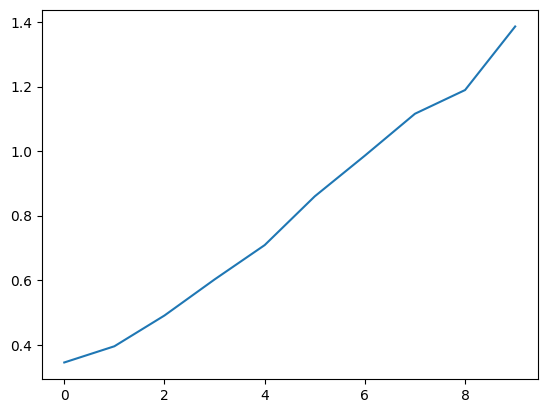

In [5]:
plt.plot(comp_time)
#plt.plot(obj_value)

In [6]:
ind_k_stacked

range(0, 16384)

In [7]:
##################### original CCG approach for computing the worst-case uncertainty scenario ###############
obj_option = "RO_orig"
def ccg_opt(necessary_data, u_set):

    UB_list = np.array([])
    LB_list = np.array([])
    
    epsilon = 0.02
    num_iter = 10
    UB = 1e8
    LB = -1e8
    ccg_str = time.time()
        
    for k_iter in range(num_iter):
        mp_x, mp_obj, mp_term_cond = MP_RO_Orig(u_set, k_iter, *necessary_data)  #### solve master problem   
        print("##################################################################")
        print("master problem termination condition: ", mp_term_cond)
            
        LB = mp_obj
        
        LB_list = np.append(LB_list, LB)
        
        sp_obj_vec = np.array([])
        u_set_iter = []
        sp_termination_status = []

        if np.abs((UB - LB)/LB) <= epsilon:
            print("first stage decision variables: ", mp_x)
            # print("worst case scenario is: ", u_set)
            break
        print("------------------------------------------------------------------")
        for k in ind_k_stacked:
            D, d = D_set_stacked[k], d_set_stacked[k]
            sp_obj, sp_u, sp_vio, sp = SP_gp_sd(mp_x, D, d, *necessary_data)  ## solve k different subproblems using strong duality or KKT
                           
            sp_obj_vec = np.append(sp_obj_vec, sp_obj)
            u_set_iter.append(sp_u)
                
        u_set.append(u_set_iter)
    

        UB_candidate = c@mp_x + np.max(sp_obj_vec)
    
        UB = min(UB, UB_candidate)
        UB_list = np.append(UB_list,UB)
        print("Lower bound is: ", LB)
        print("Upper bound is: ", UB)
    
                
        if np.abs((UB - LB)/LB) <= epsilon:
            print("first stage decision variables: ", mp_x)
            # print("worst case scenario is: ", u_set)
            break
    
    computation_time_ccg = time.time() - ccg_str
    print("computation time of ccg is: ", computation_time_ccg)

    return LB, computation_time_ccg

#mp_x, bTy_max = ccg_opt()

In [8]:
comp_time_orig = []
obj_value_orig = []

for N in tqdm(range(5,15)):
    T, W, M, AA, qq, c, b, h = generate_necessary_data(N)
    D_set_stacked, d_set_stacked = generate_D_d_stacked(N)    
    ind_k_stacked = range(len(D_set_stacked))
    ind_ut = range(1)
    idx_t = range(N)
    ind_k = range(len(D_set))
    ind_x = range(T.shape[1])
    ind_y = range(W.shape[1])
    ind_u = range(M.shape[1])
    ind_T = range(T.shape[0])
    
    #u_set = [[np.zeros(N) for k in ind_k_stacked]]
    u_set = [[np.zeros(N)]]
    necessary_data = (T, W, M, AA, qq, c, b, h, ind_x, ind_y, ind_u, ind_T, ind_k, ind_k_stacked, ind_ut, idx_t)
    obj_orig, cpu_time_orig = ccg_opt(necessary_data, u_set)
    comp_time_orig.append(cpu_time_orig)
    obj_value_orig.append(obj_orig)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  64.63681799795259
Upper bound is:  96.37856797757635


 10%|████████▎                                                                          | 1/10 [00:01<00:12,  1.44s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  1.416388750076294
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  89.02716061671953
Upper bound is:  128.87209491839374


 20%|████████████████▌                                                                  | 2/10 [00:05<00:22,  2.85s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  3.8309946060180664
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  115.32843503647175
Upper bound is:  163.279968665


 30%|████████████████████████▉                                                          | 3/10 [00:12<00:34,  4.99s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  7.518955945968628
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  203.69988307959525
Upper bound is:  259.7591116490768


 40%|█████████████████████████████████▏                                                 | 4/10 [00:29<00:56,  9.48s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  16.328744888305664
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  287.38370677996613
Upper bound is:  351.55098178440664


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:06<01:37, 19.50s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  37.19657063484192
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  367.8035557992141
Upper bound is:  440.0789900576129


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:26<02:40, 40.05s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  79.79045844078064
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  446.0207289538054
Upper bound is:  526.4043586548495


 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:23<04:14, 84.75s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  176.51647758483887
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  524.2304659101791
Upper bound is:  612.7223026655495


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [11:49<06:01, 180.90s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  386.2384424209595
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  602.4926044782716
Upper bound is:  699.0756231436249


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [26:02<06:30, 390.81s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  851.1811511516571
##################################################################
master problem termination condition:  True
------------------------------------------------------------------
Lower bound is:  681.0287238629094
Upper bound is:  785.736983421373


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [57:07<00:00, 342.75s/it]

##################################################################
master problem termination condition:  True
first stage decision variables:  [0.]
computation time of ccg is:  1862.6270802021027


In [10]:
T, W, M, c, b = generate_necessary_data(N)
ind_ut = range(1)
idx_t = range(N)
ind_k = range(len(D_set))
ind_x = range(T.shape[1])
ind_y = range(W.shape[1])
ind_u = range(M.shape[1])
ind_T = range(T.shape[0])

necessary_data = (T, W, M, c, b, ind_x, ind_y, ind_u, ind_T, ind_k, ind_k_stacked, ind_ut, ind_t)

ValueError: too many values to unpack (expected 5)

In [13]:
np.savez("time_data.npz", comp_time = comp_time, comp_time_orig = comp_time_orig, obj_value = obj_value, obj_value_orig = obj_value_orig)

In [11]:
plt.figure(figsize = (4.5,2.8))
x_label = list(range(5,15))
plt.scatter(x_label, comp_time, marker = "*", color = "blue")
plt.scatter(x_label, comp_time_orig, marker = "o", c = "none", edgecolors = "red", s = 35)
plt.yscale("log")
plt.xlabel("prediction horizon $N$")
plt.ylabel("computation time (s)")
plt.legend(["proposed approach", "conventional approach"], ncol = 1, frameon = False)
plt.savefig("comp_time_ccg.pdf", bbox_inches = "tight")

In [12]:
plt.figure(figsize = (4.5,2.8))
plt.scatter(x_label, obj_value, marker = "*", color = "blue")
plt.scatter(x_label, obj_value_orig, marker = "o", c = "none", edgecolors = "red", s = 35)
plt.xlabel("prediction horizon $N$")
plt.ylabel("objective value")
plt.legend(["proposed approach", "conventional approach"], ncol = 1, frameon = False)
plt.savefig("obj_value_ccg.pdf", bbox_inches = "tight")